In [2]:
#!/usr/bin/env python
 
'''
Test_internet.ipynb: A program to plot the data produced for the Test_internet.py script
A. J. McCulloch, January 2020
'''

####################################################################################################
# Import modules
####################################################################################################

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

####################################################################################################
# Define functions
####################################################################################################

# Function to return data without single point deviations
def returnextended(frame):
    # Choose points where there was no difference, or there is a difference and the value after is the same
    cond = (frame['connected'].diff() == 0) | (abs(frame['connected'].diff()) == 1 & (frame['connected'].sub(frame['connected'].shift(-1)) == 0))
    return frame.loc[cond == True] # Apply the condition and return

# Function to plot a dataframe. If extended is True, the plot will remove single point transistions
def dateplot(frame, TOI, duration, split = 0, plotall = False, start = None, end = None, extended = True, savefig = False):
    
    # Pandas matplotlib converters are required not to give error message
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    """
    Get the start date and end date for the plot
    Can be given by time of interest plus duration or explicitly
    Otherwise, can plot everything
    Redefine the frame between start and end dates
    """
    
    # If limits have been used, extract them
    if start != None:
        if end != None:
            start_date, end_date = start, end
        else:
            print("Start date defined but end date not defined")
            pass
    # Else use the specified time of interest and duration
    elif start == None:    
        # Plot everything if plotall is True
        if plotall == True:
            start_date, end_date = first, last
        # If plotall is False, select the relevant data
        # Variable 'split' determines the direction to select: 1 = forward, -1 = backward, 0 = split
        elif plotall == False:
            # Set maximum and minimum start and end points
            start_date = first
            end_date = last
            if (split == 0) & (duration != 0):
                # The time of interest in centre and the duration is split around
                start_date = TOI - dt.timedelta(hours=duration/2)
                end_date = TOI + dt.timedelta(hours=duration/2)

            elif (split == 1):
                # The time of interest is the fisrt timestamp and look forward by one duration
                start_date = TOI
                if duration != 0:
                    end_date = TOI + dt.timedelta(hours=duration)

            elif split == -1:
                # The time of interest is the last timestamp and look backward by one duration
                end_date = TOI
                if duration != 0:
                    start_date = TOI - dt.timedelta(hours=duration)           
    
    # Determine the duration in Days (if not already defined)
    try:
        duration
    except NameError:
        duration = end_date-start_date
        duration = duration.days * 24
    
    frame = frame.loc[start_date.strftime('%Y-%m-%d %H:%M:%S'):end_date.strftime('%Y-%m-%d %H:%M:%S')] # Select data between the start and end dates (must convert datetime object)
    
    """
    Make the plot
    This is still somewhat manual depending on plot duration
    """
        
    f, ax = plt.subplots(figsize=(14,9)) # Make a subplot to place the axis 
    
    # Full time series
    t, o = frame.index, frame['connected'] # Make lists of time and connection status
    if extended == True: #If multiple seriers are plotted, decrease the opacity
        alp = 0.5
    else:
        alp = 1.0        
    ax.plot_date(t, o, 'C0-', linewidth=1, alpha = alp) # Make it a line plot
    
    # Only extended transitions
    if extended == True:
        exframe = returnextended(frame)
        te, oe = exframe.index, exframe['connected'] # Make lists of time and connection status
        ax.plot_date(te, oe, 'C4', linewidth=2.25, alpha = 1)
    
    # format the ticks
    # For a day plot
    if duration == 24:
        # Set time parameters of the plot
        hours = mdates.HourLocator(interval = 4) # To be used for major ticks
        midhours = mdates.HourLocator(interval = 2)# To be used for minor ticks, alternative is byhour=range(0, 24, 2)
        hoursFmt = mdates.DateFormatter('%H%M') # Format of the labels
        ax.xaxis.set_major_locator(hours) # Set the major ticks
        ax.xaxis.set_major_formatter(hoursFmt) # Set the format of the ticks
        ax.xaxis.set_minor_locator(midhours) # Set the minor ticks
    else: # Manual handling below
        if plotall == True:
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    
    plt.gcf().autofmt_xdate() # Make the x-axis not complete gibberish
    plt.yticks((0,1),('Offline','Online')) # Label the y-axis ticks
    
    # Time range over which to plot
    tmin = t.min()
    tmax = t.max()
    ax.set_xlim(tmin, tmax)
    
    # Label the plot
    plt.title('Internet connection', fontsize=40)
    plt.xlabel('Time stamp', fontsize=30)
    plt.ylabel('Status', fontsize=30)
    
    if savefig == True:
        # Save the data
        outputname = frame.index[-1].strftime('%Y%m%d_%H%M-')+str(duration) # Generate the file name
        plt.savefig(outputname+'.pdf', bbox_inches='tight') # Save a .pdf

Import and process data

In [6]:
####################################################################################################
####################################################################################################
# Code starts here
####################################################################################################
####################################################################################################
        
# Import the file and read the contents
file = 'connectionlog.txt' # File to import, generated by Test_internet.py
with open(file,'r') as f_open:
    data = f_open.read() # Store the contents
    
# Process the data
data = data.replace('\x00','') # Remove any ASCII that sneaks in (there is some in my data)     
raw = [x.split(', ') for x in data.splitlines()] # Split the data
headers = raw.pop(0) # Extract and remove the headers
df = pd.DataFrame(raw, columns=headers) # Convert the data to a dataframe
df['Time stamp'] = pd.to_datetime(df['Time stamp'], format='%Y-%m-%d %H:%M:%S') # Convert time stamps to datetime objects
df['connected'] = df['connected'].apply(lambda x: int(x == 'True')) # Convert connected to boolean
df = df.set_index('Time stamp') # Set dataframe index to be the time stamp

# Store pertinent times
now = dt.datetime.now() # The time now
first = df.index[0] # The first measurement
last = df.index[-1] # The latest measurement

plt.rcParams.update({'font.size': 26})

Example: Input a time of interest and plot duration, produce and save plot

2019-03-27 02:00:00


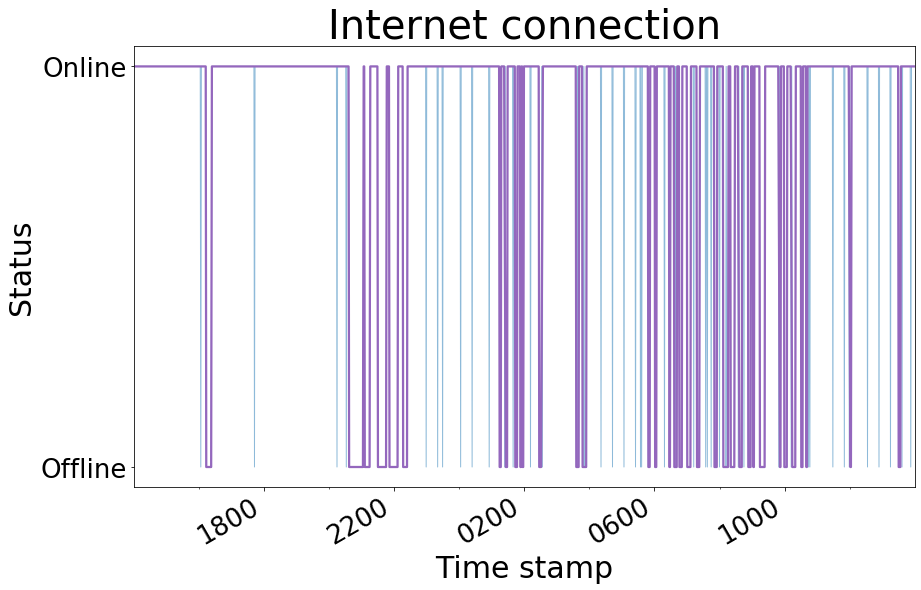

In [7]:
# Input parameters
TOI = '20190327 0200' # Time of interest, in format of YMD HM
TOIts = dt.datetime.strptime(TOI, '%Y%m%d %H%M') # Convert the time of interest to a datetime object
duration = 24 # Duration in hours
split = 0 # Set the direction to select, 1 = forward, -1 = backward, 0 = split

print(TOIts)
dateplot(df, TOIts, duration, split, savefig = True)

2020-01-31 14:18:18


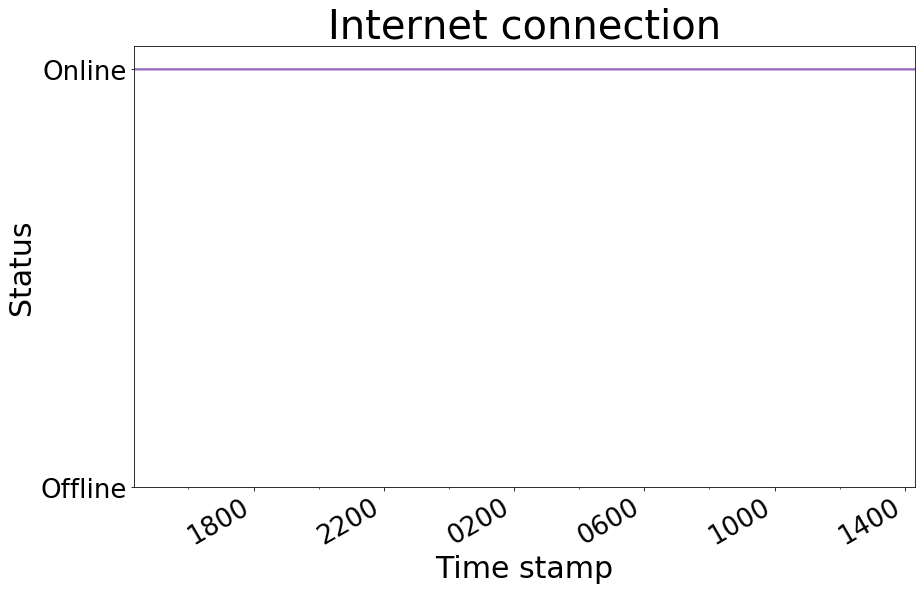

In [8]:
print(last)
dateplot(df, last, duration, -1, savefig = True)

### Plot and explore data from the TPG era
The entire TPG era

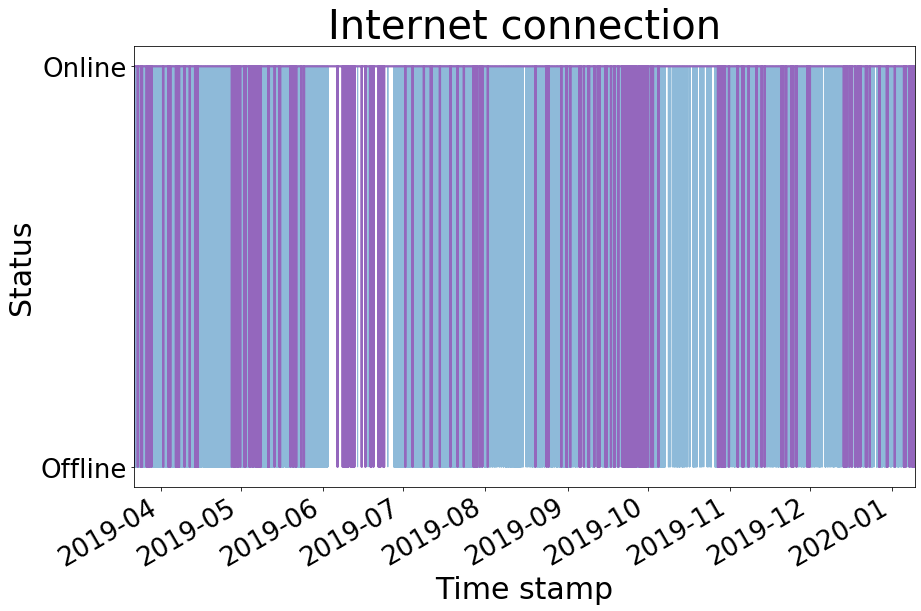

In [10]:
endtime = dt.datetime.strptime('20200109 1200', '%Y%m%d %H%M') # Time that TPG no longer supplied internet access
dateplot(df, None, None, start = first, end = endtime, extended = True, savefig = True)

Look more cloely at connection statistics

In [11]:
dftpg = df[first.strftime('%Y-%m-%d %H:%M:%S'):endtime.strftime('%Y-%m-%d %H:%M:%S')] # TPG dataframe
print(dftpg.resample('W').mean()) # Weekly connection statistics

            connected
Time stamp           
2019-03-24   0.936580
2019-03-31   0.942946
2019-04-07   0.934410
2019-04-14   0.948908
2019-04-21   0.972422
2019-04-28   0.939576
2019-05-05   0.924716
2019-05-12   0.851953
2019-05-19   0.976500
2019-05-26   0.962796
2019-06-02   0.974187
2019-06-09   0.943764
2019-06-16   0.931464
2019-06-23   0.983615
2019-06-30   0.984812
2019-07-07   0.968284
2019-07-14   0.967823
2019-07-21   0.966222
2019-07-28   0.957291
2019-08-04   0.980228
2019-08-11   0.988520
2019-08-18   0.985225
2019-08-25   0.985820
2019-09-01   0.968316
2019-09-08   0.934171
2019-09-15   0.976607
2019-09-22   0.883742
2019-09-29   0.770019
2019-10-06   0.964858
2019-10-13   0.990962
2019-10-20   0.992017
2019-10-27   0.988723
2019-11-03   0.965407
2019-11-10   0.986161
2019-11-17   0.989920
2019-11-24   0.967216
2019-12-01   0.990319
2019-12-08   0.989722
2019-12-15   0.983225
2019-12-22   0.986311
2019-12-29   0.970812
2020-01-05   0.987721
2020-01-12   0.915237


Make a plot of a particularly bad period

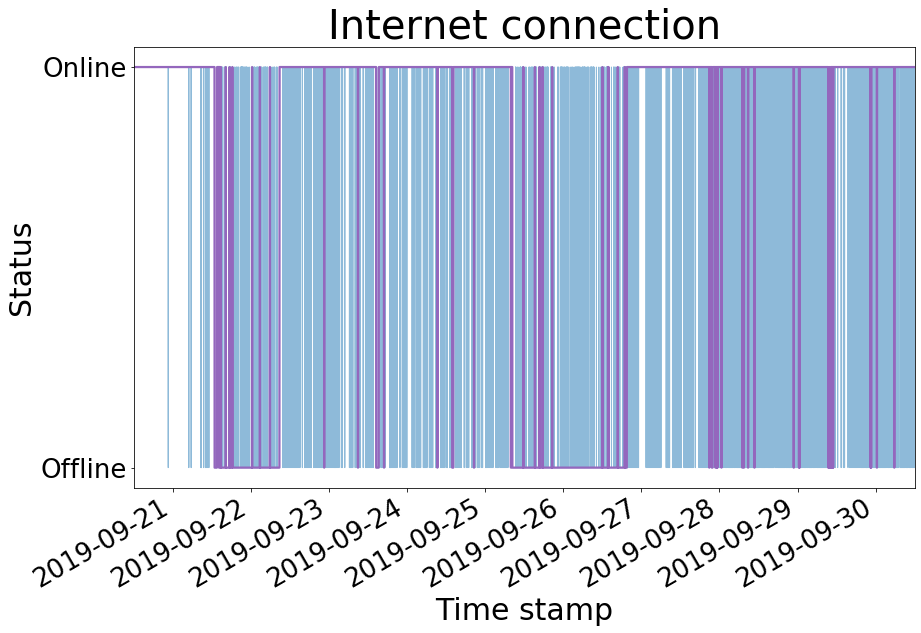

In [13]:
bad_start = dt.datetime.strptime('20190920 1200', '%Y%m%d %H%M') # Time that TPG no longer supplied internet access
bad_end = dt.datetime.strptime('20190930 1200', '%Y%m%d %H%M')
# dateplot(frame, TOI, duration, split = 0, plotall = False, start = None, end = None, extended = True, savefig = False)
dateplot(df, None, None, start = bad_start, end = bad_end, extended = True)

Make a plot of TPG connection statistics

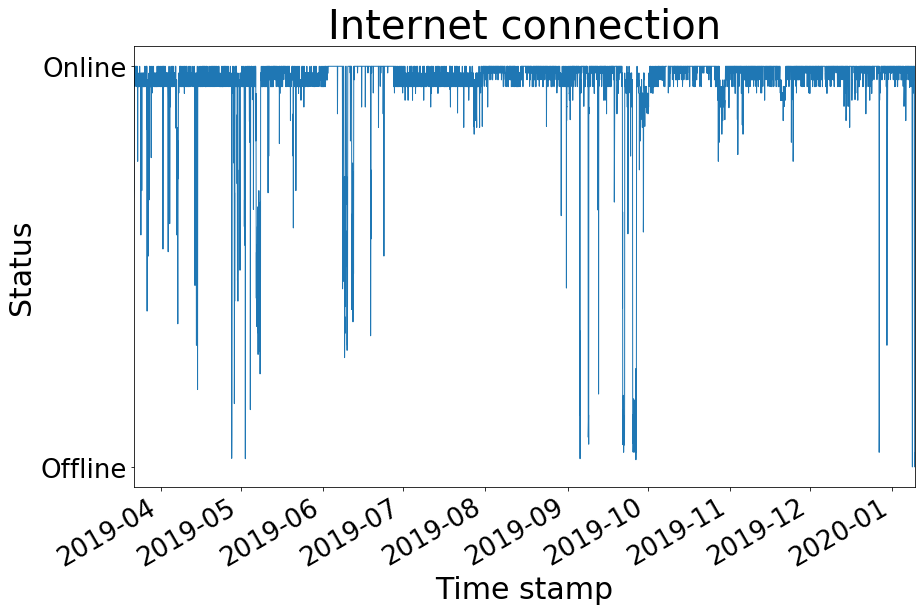

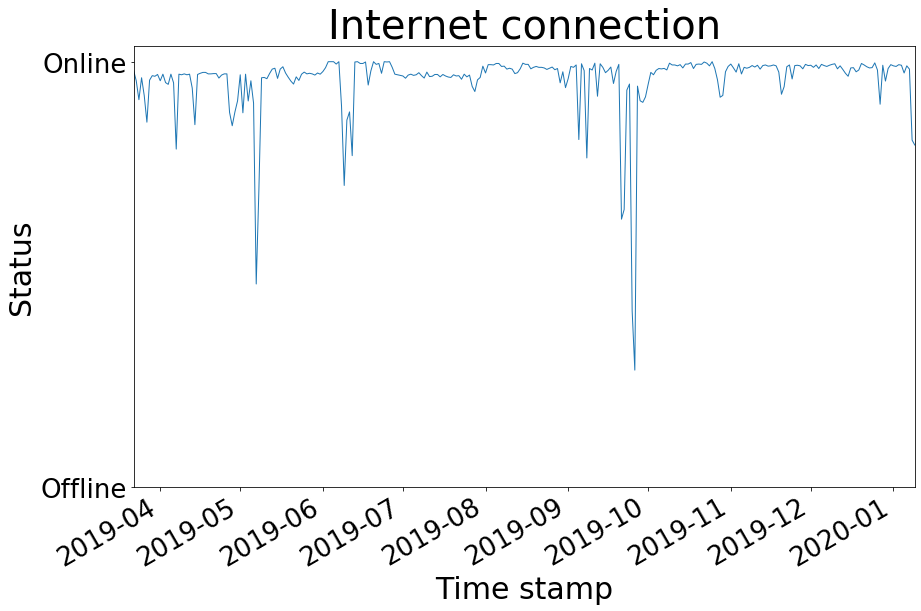

In [14]:
dftpgtp = dftpg.resample('H').mean()
dateplot(dftpgtp, None, None, start = first, end = endtime, extended = False)
dftpgtp = dftpg.resample('D').mean()
dateplot(dftpgtp, None, None, start = first, end = endtime, extended = False, savefig = True)

### Plot the Aussie Broadband Era

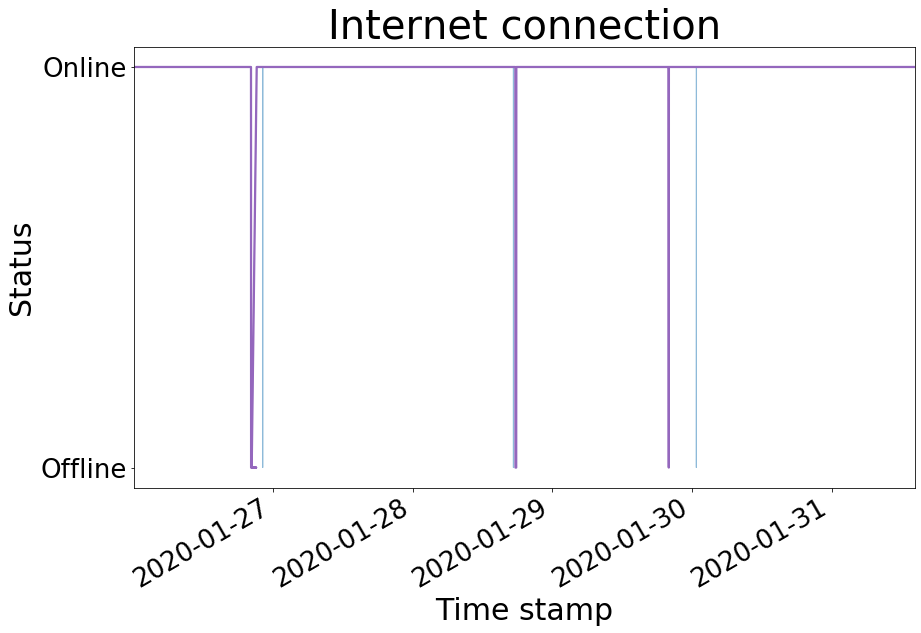

In [15]:
Aussieontime = dt.datetime.strptime('20200126 0000', '%Y%m%d %H%M') # Time that TPG no longer supplied internet access
# dateplot(frame, TOI, duration, split = 0, plotall = False, start = None, end = None, extended = True, savefig = False)
dateplot(df, None, None, start = Aussieontime, end = now, extended = True, savefig = True)